# Спринт 12 «Сборный Проект - 2»

# Проект «Восстановление золота из руды»

## Навигация

1. [Описание проекта](#Описание-проекта)
1. [Технологический процесс](#Технологический-процесс)
1. [Описание данных](#Описание-данных)
1. [Наименование признаков](#Наименование-признаков)
1. [Предобработка данных](#Предобработка-данных)
  - [Открываем файлы и изучаем их](#Открываем-файлы-и-изучаем-их)
  - [Проверяем, что эфективность обогащения рассчитана правильно](#Проверяем,-что-эфективность-обогащения-рассчитана-правильно)
  - [Проанализируем признаки, недоступные в тестовой выборке](#Проанализируем-признаки,-недоступные-в-тестовой-выборке)
  - [Проведём предобработку данных](#Проведём-предобработку-данных)
1. [Анализ данных](#Анализ-данных)
   - [Посмотрим, как меняется концентрация металлов на различных этапах очистки](#Посмотрим,-как-меняется-концентрация-металлов-на-различных-этапах-очистки)
   - [Сравним распределения размеров гранул сырья на обучающей и тестовой выборках](#Сравним-распределения-размеров-гранул-сырья-на-обучающей-и-тестовой-выборках)
   - [Исследуем суммарную концентрацию всех веществ на разных стадиях](#Исследуем-суммарную-концентрацию-всех-веществ-на-разных-стадиях)
1. [Модель](#Модель)
   - [Напишем функцию для вычисления итоговой sMAPE](#Напишем-функцию-для-вычисления-итоговой-sMAPE)
   - [Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модль и проверим её на тестовой выборке](#Обучим-разные-модели-и-оценим-их-качество-кросс-валидацией.-Выберем-лучшую-модль-и-проверим-её-на-тестовой-выборке)
1. [Общие выводы](#Общие-выводы)

## Описание проекта

[к навигации](#Навигация)

Необходимо подготоить прототип модели машинного обучения для [«Цифры»](https://www.zyfra.com/ru/). Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Будем использовать данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Технологический процесс

[к навигации](#Навигация)

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

![](viruchka_1576238830.jpg)

Опишем каждую стадию: 
1. Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.

На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Описание данных

[к навигации](#Навигация)

**Технологический процесс**
- `Rougher feed` — исходное сырье
- `Rougher additions` (или `reagent additions`) — флотационные реагенты: Xanthate, Sulphate, Depressant
- `Xanthate` — ксантогенат (промотер, или активатор флотации);
- `Sulphate` — сульфат (на данном производстве сульфид натрия);
- `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота

**Параметры этапов**
- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

## Наименование признаков

[к навигации](#Навигация)

Наименование признаков должно быть такое:  
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики

In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
sns.set_theme()
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor

In [2]:
RANDOM_STATE = 42

## Предобработка данных

[к навигации](#Навигация)

### Открываем файлы и изучаем их

[к навигации](#Навигация)

In [3]:
train_data = pd.read_csv(os.path.join('..', 'datasets', 'gold_recovery_train_new.csv'), index_col='date')
train_data.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [5]:
test_data = pd.read_csv(os.path.join('..', 'datasets', 'gold_recovery_test_new.csv'), index_col='date')
test_data.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

In [7]:
full_data = pd.read_csv(os.path.join('..', 'datasets', 'gold_recovery_full_new.csv'), index_col='date')
full_data.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [8]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

### Проверяем, что эфективность обогащения рассчитана правильно

[к навигации](#Навигация)

In [9]:
def get_recovery(row, c_col, f_col, t_col):
    c = row[c_col]  # доля золота в концентрате после флортации/очистки
    f = row[f_col]  # доля золота в сырье/концентрате до флотации/очистки
    t = row[t_col]  # доля золота в отвальных хвостах после флортации/очистки

    recovery = ((c * (f - t)) / (f * (c - t))) * 100

    return recovery


def get_rougher_recovery(row):
    return get_recovery(
        row,
        c_col='rougher.output.concentrate_au',
        f_col='rougher.input.feed_au',
        t_col='rougher.output.tail_au',
    )


def get_final_recovery(row):
    return get_recovery(
        row,
        c_col='final.output.concentrate_au',
        f_col='rougher.output.concentrate_au',
        t_col='final.output.tail_au',
    )

In [10]:
my_rougher_recovery = train_data.apply(get_rougher_recovery, axis=1)
print('MAE:', mean_absolute_error(my_rougher_recovery, train_data['rougher.output.recovery']))

MAE: 9.73512347450521e-15


In [11]:
# для оценки значений
my_rougher_recovery = pd.Series(my_rougher_recovery)
my_rougher_recovery.describe()

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
dtype: float64

__Вывод__: MAE имеет невероятно малое значение, значит `recovery` рассчитано верно.

### Проанализируем признаки, недоступные в тестовой выборке

[к навигации](#Навигация)

In [12]:
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)
full_columns = set(full_data.columns)

train_columns - test_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

- в основном отсутствуют данные по результатам этапов обработки руды
- ещё отсутствуют расчитанные значения

### Проведём предобработку данных

[к навигации](#Навигация)

In [13]:
if len(train_columns & test_columns) == 0:
    print('Отлично, пересечений по индексам нет.')
else:
    print('Хм ...')

Хм ...


In [14]:
if len(full_columns & train_columns) == len(train_columns):
    print('В full присутствуют все train')
else:
    print('Хм ...')

В full присутствуют все train


In [15]:
if len(full_columns & test_columns) == len(test_columns):
    print('В full присутствуют все test')
else:
    print('Хм ...')

В full присутствуют все test


In [16]:
rougher_features = [
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_rate',
    'rougher.input.feed_size',
    'rougher.input.feed_sol',
    'rougher.input.feed_au',
    'rougher.input.floatbank10_sulfate',
    'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate',
    'rougher.input.floatbank11_xanthate',
]
# другие признаки брать нельзя: произойдёт data leak
X_train_rougher = full_data.loc[train_data.index, rougher_features]
y_train_rougher = full_data.loc[train_data.index, 'rougher.output.recovery']

X_test_rougher = full_data.loc[test_data.index, rougher_features]
y_test_rougher = full_data.loc[test_data.index, 'rougher.output.recovery']

In [17]:
final_features = [
    'primary_cleaner.output.concentrate_ag',
    'primary_cleaner.output.concentrate_pb',
    'primary_cleaner.output.concentrate_sol',
    'primary_cleaner.output.concentrate_au',
    'secondary_cleaner.state.floatbank2_a_air',
    'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_air',
    'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_air',
    'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_air',
    'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_air',
    'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_air',
    'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_air',
    'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_air',
    'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_air',
    'secondary_cleaner.state.floatbank6_a_level',
]
X_train_final = full_data.loc[train_data.index, final_features]
y_train_final = full_data.loc[train_data.index, 'final.output.recovery']

X_test_final = full_data.loc[test_data.index, final_features]
y_test_final = full_data.loc[test_data.index, 'final.output.recovery']

In [18]:
X_train_rougher = X_train_rougher.fillna(method='ffill')
X_test_rougher = X_test_rougher.fillna(method='ffill')

X_train_final = X_train_final.fillna(method='ffill')
X_test_final = X_test_final.fillna(method='ffill')

## Анализ данных

[к навигации](#Навигация)

### Посмотрим, как меняется концентрация металлов на различных этапах очистки

[к навигации](#Навигация)

In [19]:
analysis_columns = [
    # сырье
    'rougher.input.feed_au',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    # после флорации
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    # после первого этапа очистки
    'primary_cleaner.output.concentrate_au',
    'primary_cleaner.output.concentrate_ag',
    'primary_cleaner.output.concentrate_pb',
    # после второго этапа очистки
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    # размер гранул сырья
    'rougher.input.feed_size',
]
train_analysis = full_data.loc[train_data.index, analysis_columns]
test_analysis = full_data.loc[test_data.index, analysis_columns]

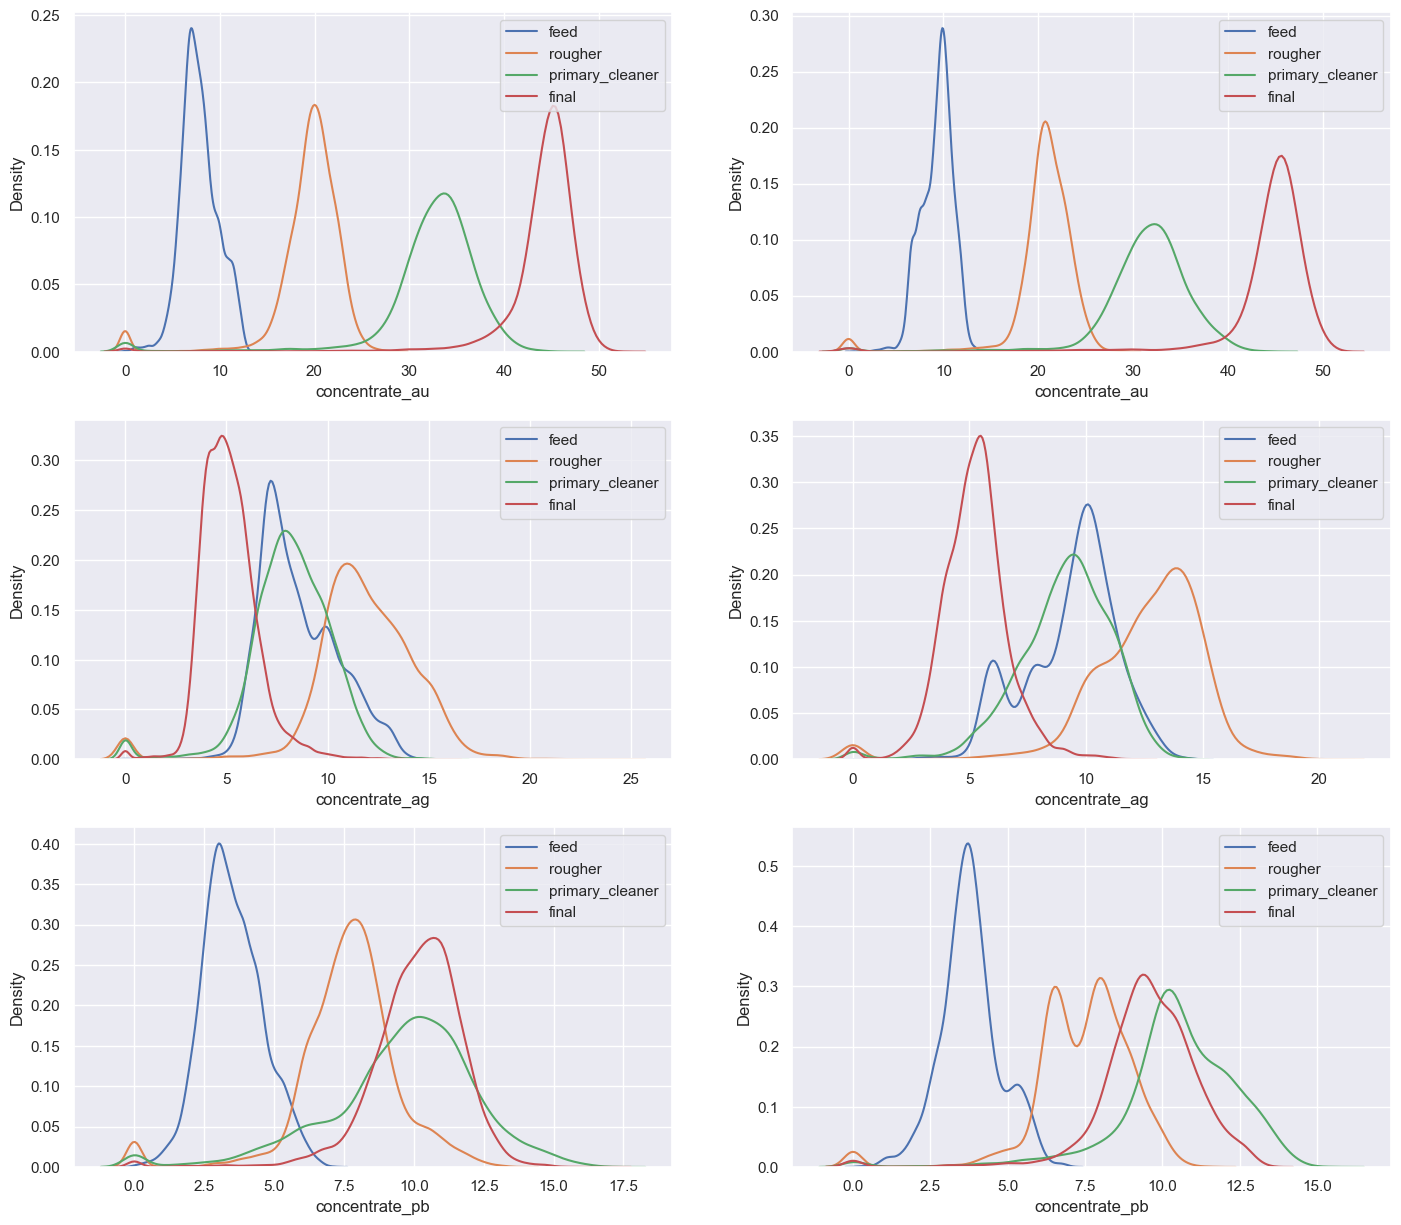

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(17, 15))

for i, metal in enumerate(['au', 'ag', 'pb']):
    sns.kdeplot(data=train_analysis, x=f'rougher.input.feed_{metal}', ax=axes[i, 0], label='feed')
    sns.kdeplot(data=train_analysis, x=f'rougher.output.concentrate_{metal}', ax=axes[i, 0], label='rougher')
    sns.kdeplot(data=train_analysis, x=f'primary_cleaner.output.concentrate_{metal}', ax=axes[i, 0], label='primary_cleaner')
    sns.kdeplot(data=train_analysis, x=f'final.output.concentrate_{metal}', ax=axes[i, 0], label='final')
    axes[i, 0].set_xlabel(f'concentrate_{metal}')
    axes[i, 0].legend()

    sns.kdeplot(data=test_analysis, x=f'rougher.input.feed_{metal}', ax=axes[i, 1], label='feed')
    sns.kdeplot(data=test_analysis, x=f'rougher.output.concentrate_{metal}', ax=axes[i, 1], label='rougher')
    sns.kdeplot(data=test_analysis, x=f'primary_cleaner.output.concentrate_{metal}', ax=axes[i, 1], label='primary_cleaner')
    sns.kdeplot(data=test_analysis, x=f'final.output.concentrate_{metal}', ax=axes[i, 1], label='final')
    axes[i, 1].set_xlabel(f'concentrate_{metal}')
    axes[i, 1].legend()

plt.show()

__Выводы__:
- Концентрация Au на каждом этапе растёт. train и test схожи
- Концентрация Ag меняется неравномерно. train и test схожи
- На train концентраци Pb растёт с каждым этапом. На последнем шаге уменьшается дисперсия, носохраняется среднее. На test концентраци Pb меняется неравномерно. Можно заметить разницу в дисперсиях между train и test на всех шагах кроме сырья.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

[к навигации](#Навигация)

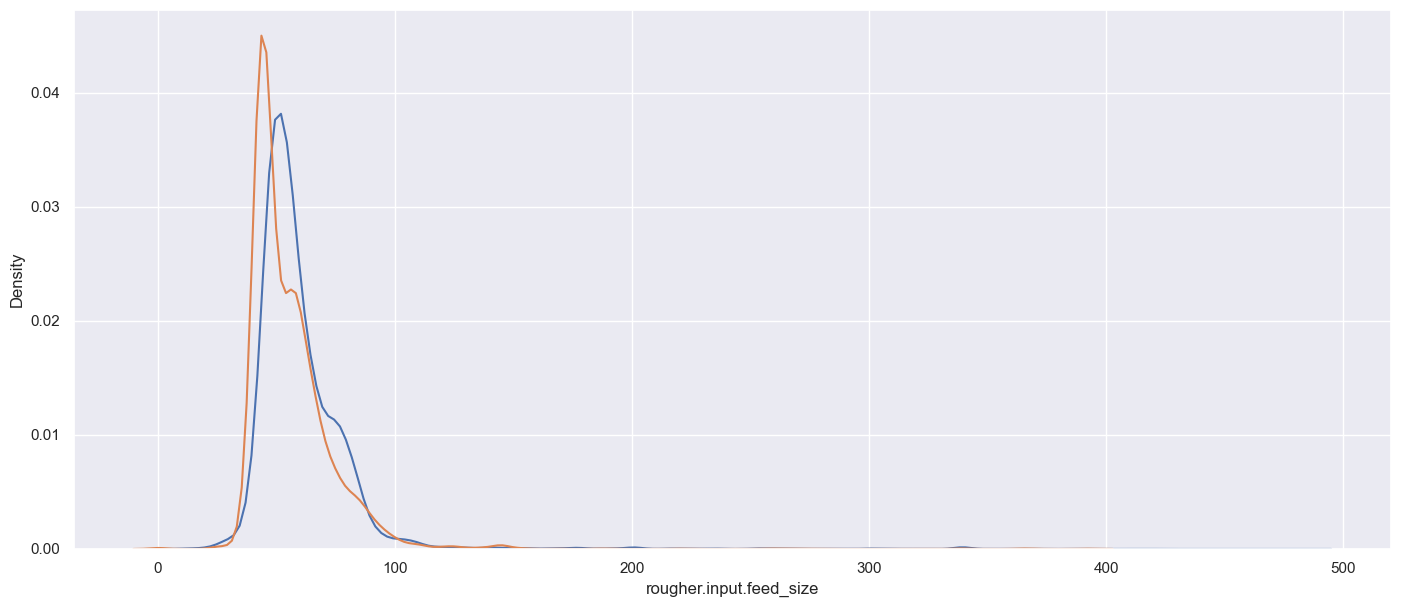

In [21]:
fig, ax = plt.subplots(figsize=(17, 7))

sns.kdeplot(data=train_analysis, x='rougher.input.feed_size', ax=ax)
sns.kdeplot(data=test_analysis, x='rougher.input.feed_size', ax=ax)

plt.show()

__Вывод__: распределения весьма схожи.

### Исследуем суммарную концентрацию всех веществ на разных стадиях

[к навигации](#Навигация)

In [22]:
full_data['feed_concentrate'] = full_data[[
    'rougher.input.feed_ag',
    'rougher.input.feed_au',
    'rougher.input.feed_pb',
]].sum(axis=1)

full_data['rougher_concentrate'] = full_data[[
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_pb',
]].sum(axis=1)

full_data['final_concentrate'] = full_data[[
    'final.output.concentrate_ag',
    'final.output.concentrate_au',
    'final.output.concentrate_pb',
]].sum(axis=1)

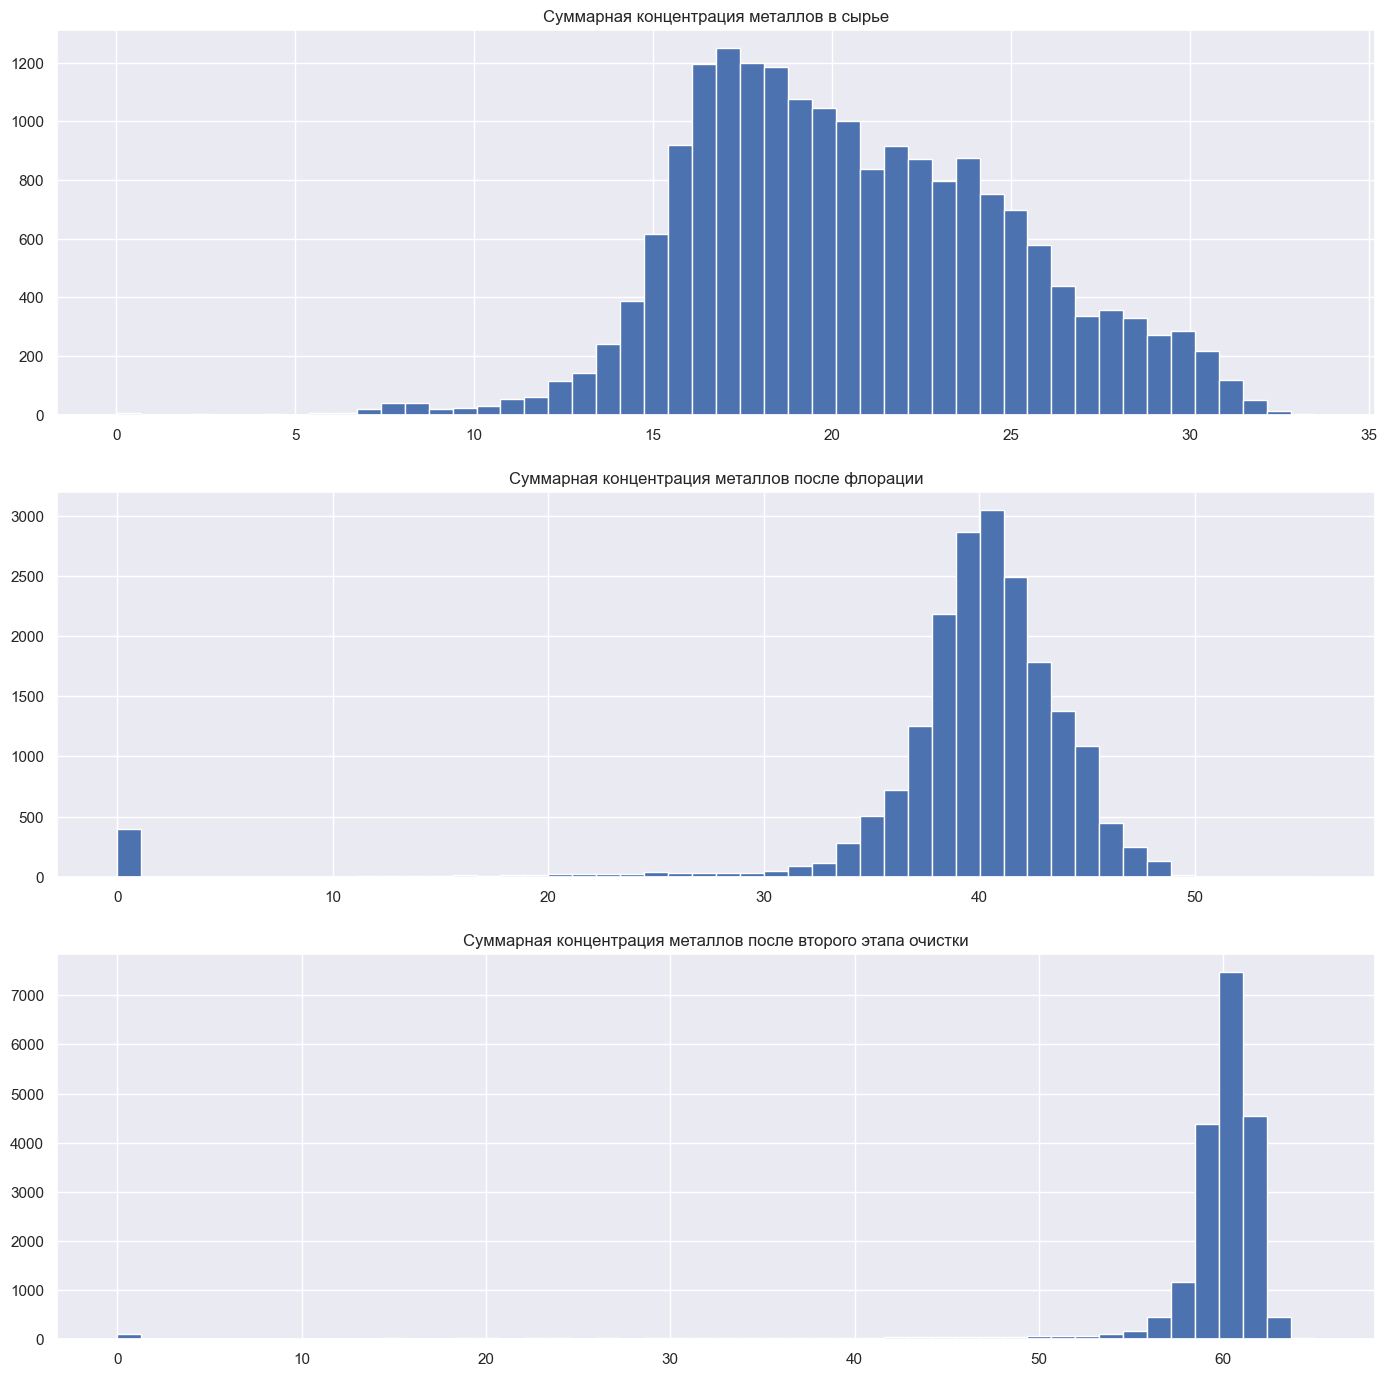

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(17, 17))

full_data['feed_concentrate'].hist(bins=50, ax=axes[0])
axes[0].set_title('Суммарная концентрация металлов в сырье')
full_data['rougher_concentrate'].hist(bins=50, ax=axes[1])
axes[1].set_title('Суммарная концентрация металлов после флорации')
full_data['final_concentrate'].hist(bins=50, ax=axes[2])
axes[2].set_title('Суммарная концентрация металлов после второго этапа очистки')

plt.show()

In [24]:
drop_index = full_data[
    (full_data['feed_concentrate'] == 0) | (full_data['rougher_concentrate'] == 0) | (full_data['final_concentrate'] == 0)
].index

In [25]:
index_train = list(set(X_train_rougher.index) - set(drop_index))
index_test = list(set(X_test_rougher.index) - set(drop_index))

In [26]:
X_train_rougher = X_train_rougher.loc[index_train]
y_train_rougher = y_train_rougher.loc[index_train]
X_train_final = X_train_final.loc[index_train]
y_train_final = y_train_final.loc[index_train]

X_test_rougher = X_test_rougher.loc[index_test]
y_test_rougher = y_test_rougher.loc[index_test]
X_test_final = X_test_final.loc[index_test]
y_test_final = y_test_final.loc[index_test]

## Модель

[к навигации](#Навигация)

### Напишем функцию для вычисления итоговой sMAPE

[к навигации](#Навигация)

In [27]:
def sMAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred) + 1e-15) / 2
    
    result = np.mean(numerator / denominator) * 100
    
    return result


def final_sMAPE(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    return 0.25 * sMAPE(y_true_rougher, y_pred_rougher) + 0.75 * sMAPE(y_true_final, y_pred_final)


smape_score = make_scorer(sMAPE, greater_is_better=False)

### Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модль и проверим её на тестовой выборке

[к навигации](#Навигация)

In [28]:
%%time
# DecisionTreeRegressor
grid_search_r = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid={'max_depth': list(range(1, 16, 2))},
    scoring=smape_score,
    n_jobs=-1,
    cv=ShuffleSplit(
        n_splits=5,
        test_size=0.25,
        random_state=RANDOM_STATE,
    ),
)
grid_search_r.fit(X_train_rougher, y_train_rougher)

CPU times: total: 781 ms
Wall time: 5.09 s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15]},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [29]:
print(f'Лучший гиперпараметр {grid_search_r.best_params_}\n'
      f'Лучший score {grid_search_r.best_score_}')

Лучший гиперпараметр {'max_depth': 15}
Лучший score -4.271856434622891


In [30]:
%%time
# RandomForestRegressor
grid_search_r = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    param_grid={'max_depth': list(range(1, 16, 2))},
    scoring=smape_score,
    n_jobs=-1,
    cv=ShuffleSplit(
        n_splits=5,
        test_size=0.25,
        random_state=RANDOM_STATE,
    ),
)
grid_search_r.fit(X_train_rougher, y_train_rougher)

CPU times: total: 10.1 s
Wall time: 1min 10s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15]},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [31]:
print(f'Лучший гиперпараметр {grid_search_r.best_params_}\n'
      f'Лучший score {grid_search_r.best_score_}')

Лучший гиперпараметр {'max_depth': 15}
Лучший score -3.385898976177559


In [32]:
model_rougher = grid_search_r.best_estimator_

---

In [33]:
%%time
# DecisionTreeRegressor
grid_search_f = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid={'max_depth': list(range(1, 16, 2))},
    scoring=smape_score,
    n_jobs=-1,
    cv=ShuffleSplit(
        n_splits=5,
        test_size=0.25,
        random_state=RANDOM_STATE,
    ),
)
grid_search_f.fit(X_train_final, y_train_final)

CPU times: total: 422 ms
Wall time: 2.64 s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15]},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [34]:
print(f'Лучший гиперпараметр {grid_search_f.best_params_}\n'
      f'Лучший score {grid_search_f.best_score_}')

Лучший гиперпараметр {'max_depth': 7}
Лучший score -8.479199842686473


In [35]:
%%time
# RandomForestRegressor
grid_search_f = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    param_grid={'max_depth': list(range(1, 16, 2))},
    scoring=smape_score,
    n_jobs=-1,
    cv=ShuffleSplit(
        n_splits=5,
        test_size=0.25,
        random_state=RANDOM_STATE,
    ),
)
grid_search_f.fit(X_train_final, y_train_final)

CPU times: total: 22 s
Wall time: 2min 7s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15]},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [36]:
print(f'Лучший гиперпараметр {grid_search_f.best_params_}\n'
      f'Лучший score {grid_search_f.best_score_}')

Лучший гиперпараметр {'max_depth': 15}
Лучший score -6.8778061010190115


In [37]:
model_final = grid_search_f.best_estimator_

In [38]:
y_pred_rougher = model_rougher.predict(X_train_rougher)
y_pred_final = model_final.predict(X_train_final)
final_sMAPE(y_train_rougher, y_pred_rougher, y_train_final, y_pred_final)

3.775709239793528

In [39]:
y_pred_rougher = model_rougher.predict(X_test_rougher)
y_pred_final = model_final.predict(X_test_final)
final_sMAPE(y_test_rougher, y_pred_rougher, y_test_final, y_pred_final)

9.254515627745619

## Общие выводы

[к навигации](#Навигация)

В результате выполнения проекта мы получили две модели, которые предсказывают коэффициент восстановления золота из золотосодержащей руды после этапа флотации и финальной очистки.
- Для этого мы проверили, правильно ли вычисляется коэффициент в размеченных данных.
- Предобработали данные, верно выбрав признаки для обучения моделей и заполнив пропуски.
- Исследовали как меняются концентрации металлов на разных этапах очистки.
- Проверили нет ли сдвига в целевом признаке между train и test.
- Выбрали лучшие модели с использованием кросс-валидации. И наконец оценили модель на тестовой выборке.